In [9]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

# Adjust the path as needed
data_path = '../../data/nifty/test/featured.csv'
df = pd.read_csv(data_path)

# Ensure date is datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

Cell 2: Find Local Highs and Lows

In [10]:
n = 3  # Window size for local extrema

df['local_max'] = df['close'][
    argrelextrema(df['close'].values, np.greater_equal, order=n)[0]
]
df['local_min'] = df['close'][
    argrelextrema(df['close'].values, np.less_equal, order=n)[0]
]

Extract Highs/Lows and Identify Higher/Lower Highs/Lows

In [11]:
# Extract local highs and lows, keeping their position in the main DataFrame
highs = df.dropna(subset=['local_max']).reset_index()
lows = df.dropna(subset=['local_min']).reset_index()

# Identify higher highs and higher lows
highs['higher_high'] = highs['local_max'] > highs['local_max'].shift(1)
lows['higher_low'] = lows['local_min'] > lows['local_min'].shift(1)

# Identify lower highs and lower lows
highs['lower_high'] = highs['local_max'] < highs['local_max'].shift(1)
lows['lower_low'] = lows['local_min'] < lows['local_min'].shift(1)

Assign Dow Theory Trend Labels

In [12]:
# Initialize trend column
df['dow_trend'] = 'Sideways'

# Mark uptrend at points where both higher high and higher low are True
for _, high_row in highs.iterrows():
    idx = high_row['index']
    if high_row['higher_high']:
        prev_lows = lows[lows['index'] < idx]
        if not prev_lows.empty and prev_lows.iloc[-1]['higher_low']:
            df.at[idx, 'dow_trend'] = 'Uptrend'

# Mark downtrend at points where both lower high and lower low are True
for _, high_row in highs.iterrows():
    idx = high_row['index']
    if high_row['lower_high']:
        prev_lows = lows[lows['index'] < idx]
        if not prev_lows.empty and prev_lows.iloc[-1]['lower_low']:
            df.at[idx, 'dow_trend'] = 'Downtrend'

Forward Fill Trend for Visualization

In [13]:
# Forward fill the trend to make it continuous for plotting
df['dow_trend'] = df['dow_trend'].replace('Sideways', np.nan)
df['dow_trend'] = df['dow_trend'].ffill().fillna('Sideways')

View or Plot the Trend

In [14]:
# View the last 20 rows with trend labels
print(df[['date', 'close', 'dow_trend']].tail(20))


                         date     close  dow_trend
117 2025-06-23 00:00:00+05:30  24971.90    Uptrend
118 2025-06-24 00:00:00+05:30  25044.35    Uptrend
119 2025-06-25 00:00:00+05:30  25244.75    Uptrend
120 2025-06-26 00:00:00+05:30  25549.00    Uptrend
121 2025-06-27 00:00:00+05:30  25637.80    Uptrend
122 2025-06-30 00:00:00+05:30  25517.05    Uptrend
123 2025-07-01 00:00:00+05:30  25541.80    Uptrend
124 2025-07-02 00:00:00+05:30  25453.40    Uptrend
125 2025-07-03 00:00:00+05:30  25405.30    Uptrend
126 2025-07-04 00:00:00+05:30  25461.00    Uptrend
127 2025-07-07 00:00:00+05:30  25461.30    Uptrend
128 2025-07-08 00:00:00+05:30  25522.50    Uptrend
129 2025-07-09 00:00:00+05:30  25476.10    Uptrend
130 2025-07-10 00:00:00+05:30  25355.25    Uptrend
131 2025-07-11 00:00:00+05:30  25149.85    Uptrend
132 2025-07-14 00:00:00+05:30  25082.30    Uptrend
133 2025-07-15 00:00:00+05:30  25195.80    Uptrend
134 2025-07-16 00:00:00+05:30  25212.05  Downtrend
135 2025-07-17 00:00:00+05:30  

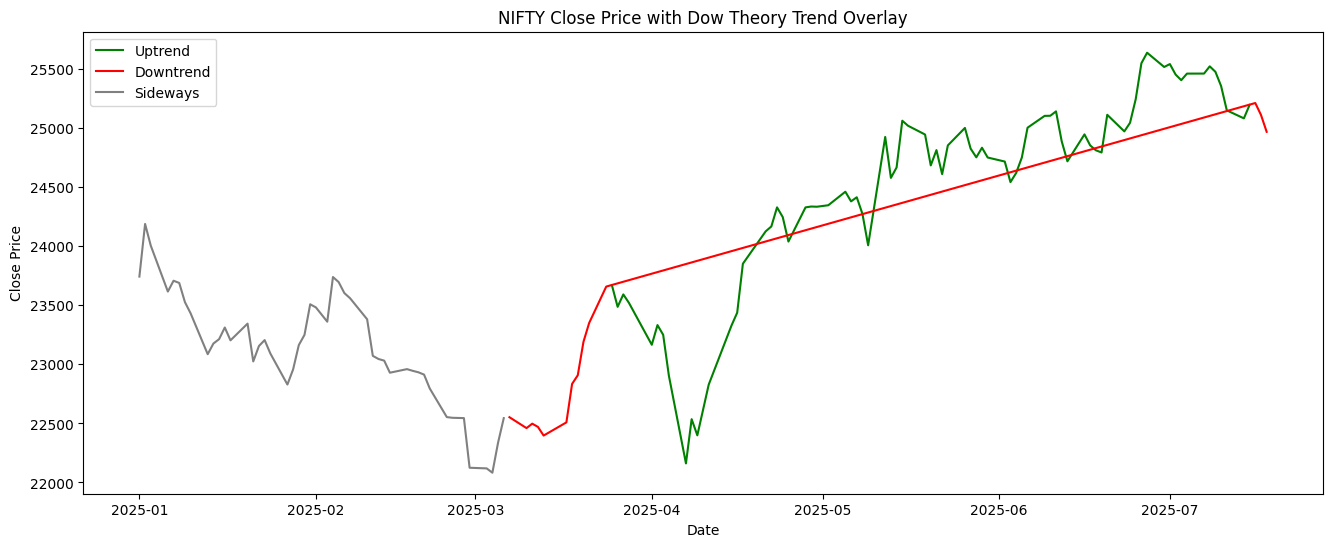

In [15]:
trend_colors = {'Uptrend': 'green', 'Downtrend': 'red', 'Sideways': 'gray'}
plt.figure(figsize=(16,6))
for trend, color in trend_colors.items():
    mask = df['dow_trend'] == trend
    plt.plot(df.loc[mask, 'date'], df.loc[mask, 'close'], color=color, label=trend)
plt.title('NIFTY Close Price with Dow Theory Trend Overlay')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()